**Importing Libraries**

In [1]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import torchvision.transforms as T

**Helper Functions**

In [2]:
def decode_segmap(image, source, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  
  rgb = np.stack([r, g, b], axis=2)

  # Load the foreground input image 
  foreground = cv2.imread(source)

  # Change the color of foreground image to RGB 
  # and resize image to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

  # Create a background array to hold white pixels
  # with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)

  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)  
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)  
  
  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)

  # Return a normalized output image for display
  return outImage/255

In [84]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def segment(net, path, show_orig=True, dev='cuda'):

  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)

  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
  rgb = decode_segmap(om, path)
  
  plt.imshow(rgb); plt.axis('off'); plt.show()
  #plt.savefig('resultant_images/{}_{}_background_removal.png'.format(path[9:13],namestr(net, globals())[0]))

**Downloading various pretrained models from torchvision and making predictions**

In [4]:
fcn_resnet50 = models.segmentation.fcn_resnet50(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


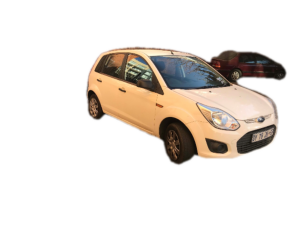

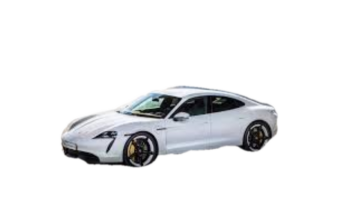

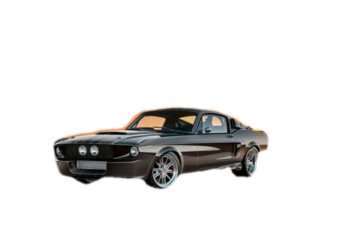

<Figure size 432x288 with 0 Axes>

In [65]:
segment(fcn_resnet50, '/content/car1.png', show_orig=False)
segment(fcn_resnet50, '/content/car2.png', show_orig=False)
segment(fcn_resnet50, '/content/car3.png', show_orig=False)

In [5]:
fcn_resnet101 = models.segmentation.fcn_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


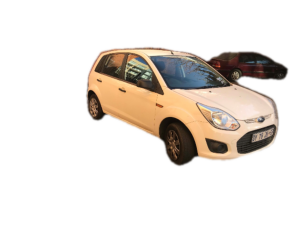

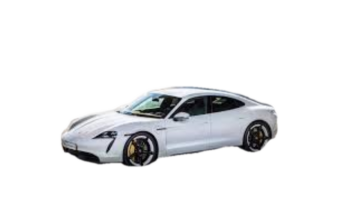

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


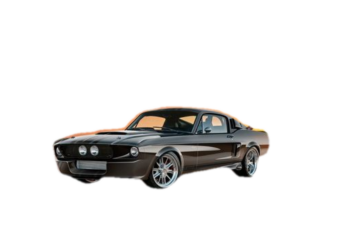

<Figure size 432x288 with 0 Axes>

In [61]:
segment(fcn_resnet101, '/content/car1.png', show_orig=False)
segment(fcn_resnet101, '/content/car2.png', show_orig=False)
segment(fcn_resnet101, '/content/car3.png', show_orig=False)

In [6]:
deeplabv3_resnet50 = models.segmentation.deeplabv3_resnet50(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


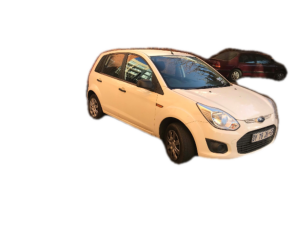

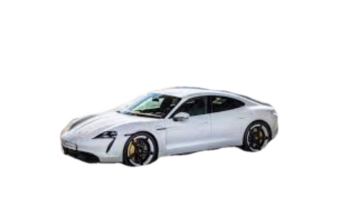

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


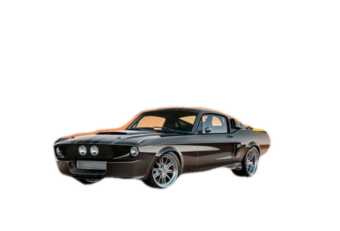

<Figure size 432x288 with 0 Axes>

In [57]:
segment(deeplabv3_resnet50, '/content/car1.png', show_orig=False)
segment(deeplabv3_resnet50, '/content/car2.png', show_orig=False)
segment(deeplabv3_resnet50, '/content/car3.png', show_orig=False)

In [7]:
deeplabv3_resnet101 = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


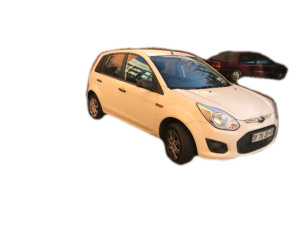

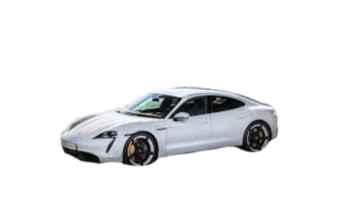

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


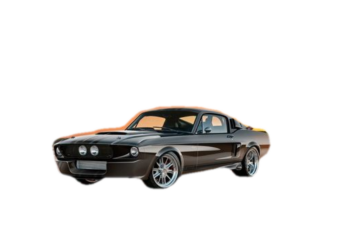

<Figure size 432x288 with 0 Axes>

In [58]:
segment(deeplabv3_resnet101, '/content/car1.png', show_orig=False)
segment(deeplabv3_resnet101, '/content/car2.png', show_orig=False)
segment(deeplabv3_resnet101, '/content/car3.png', show_orig=False)

In [8]:
deeplabv3_mobilenet_v3_large = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


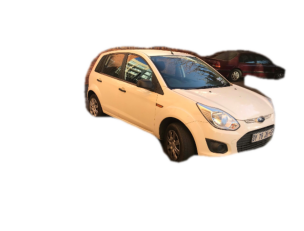

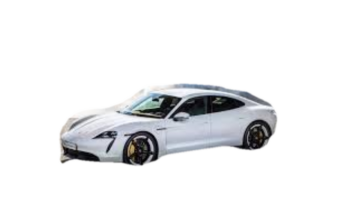

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


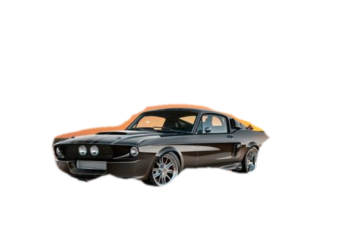

<Figure size 432x288 with 0 Axes>

In [69]:
segment(deeplabv3_mobilenet_v3_large, '/content/car1.png', show_orig=False)
segment(deeplabv3_mobilenet_v3_large, '/content/car2.png', show_orig=False)
segment(deeplabv3_mobilenet_v3_large, '/content/car3.png', show_orig=False)

In [9]:
lraspp_mobilenet_v3_large = models.segmentation.lraspp_mobilenet_v3_large(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


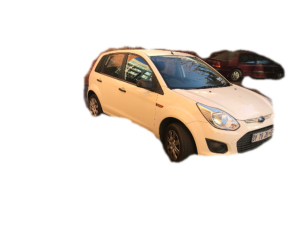

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


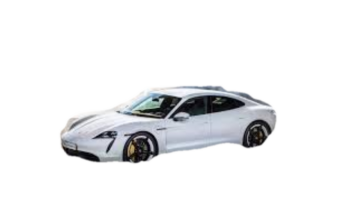

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


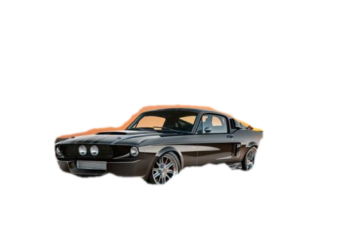

<Figure size 432x288 with 0 Axes>

In [70]:
segment(lraspp_mobilenet_v3_large, '/content/car1.png', show_orig=False)
segment(lraspp_mobilenet_v3_large, '/content/car2.png', show_orig=False)
segment(lraspp_mobilenet_v3_large, '/content/car3.png', show_orig=False)

**Inference Time**

In [74]:
import time

def infer_time(net, path='/content/car1.png', dev='cuda'):
  img = Image.open(path)
  trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  
  inp = trf(img).unsqueeze(0).to(dev)
  
  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()
  
  return et - st

**Evaluation of various models on CPU**

In [75]:
avg_over = 100

fcn_resnet50_infer_time_list_cpu = [infer_time(fcn_resnet50, dev='cpu') for _ in range(avg_over)]
fcn_resnet50_infer_time_avg_cpu = sum(fcn_resnet50_infer_time_list_cpu) / avg_over

fcn_resnet101_infer_time_list_cpu = [infer_time(fcn_resnet101, dev='cpu') for _ in range(avg_over)]
fcn_resnet101_infer_time_avg_cpu = sum(fcn_resnet101_infer_time_list_cpu) / avg_over

deeplabv3_resnet50_infer_time_list_cpu = [infer_time(deeplabv3_resnet50, dev='cpu') for _ in range(avg_over)]
deeplabv3_resnet50_infer_time_avg_cpu = sum(deeplabv3_resnet50_infer_time_list_cpu) / avg_over

deeplabv3_resnet101_infer_time_list_cpu = [infer_time(deeplabv3_resnet101, dev='cpu') for _ in range(avg_over)]
deeplabv3_resnet101_infer_time_avg_cpu = sum(deeplabv3_resnet101_infer_time_list_cpu) / avg_over

deeplabv3_mobilenet_v3_large_infer_time_list_cpu = [infer_time(deeplabv3_mobilenet_v3_large, dev='cpu') for _ in range(avg_over)]
deeplabv3_mobilenet_v3_large_infer_time_avg_cpu = sum(deeplabv3_mobilenet_v3_large_infer_time_list_cpu) / avg_over

lraspp_mobilenet_v3_large_infer_time_list_cpu = [infer_time(lraspp_mobilenet_v3_large, dev='cpu') for _ in range(avg_over)]
lraspp_mobilenet_v3_large_infer_time_avg_cpu = sum(lraspp_mobilenet_v3_large_infer_time_list_cpu) / avg_over


print ('The Average Inference time on fcn_resnet50 is:     {:.2f}s'.format(fcn_resnet50_infer_time_avg_cpu))
print ('The Average Inference time on fcn_resnet101 is: {:.2f}s'.format(fcn_resnet101_infer_time_avg_cpu))
print ('The Average Inference time on deeplabv3_resnet50 is:     {:.2f}s'.format(deeplabv3_resnet50_infer_time_avg_cpu))
print ('The Average Inference time on deeplabv3_resnet101 is: {:.2f}s'.format(deeplabv3_resnet101_infer_time_avg_cpu))
print ('The Average Inference time on deeplabv3_mobilenet_v3_large is:     {:.2f}s'.format(deeplabv3_mobilenet_v3_large_infer_time_avg_cpu))
print ('The Average Inference time on lraspp_mobilenet_v3_large is: {:.2f}s'.format(lraspp_mobilenet_v3_large_infer_time_avg_cpu))

The Average Inference time on fcn_resnet50 is:     0.76s
The Average Inference time on fcn_resnet101 is: 1.15s
The Average Inference time on deeplabv3_resnet50 is:     0.95s
The Average Inference time on deeplabv3_resnet101 is: 1.34s
The Average Inference time on deeplabv3_mobilenet_v3_large is:     0.18s
The Average Inference time on lraspp_mobilenet_v3_large is: 0.13s


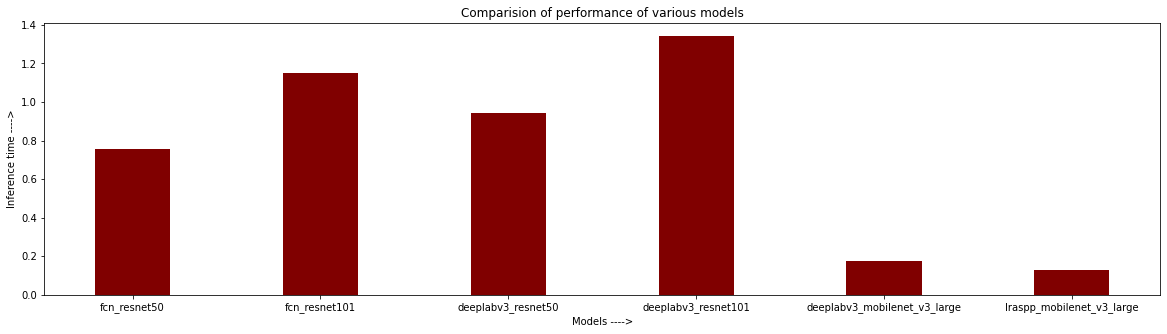

In [79]:
# Plotting Bar chart for Inference Times
 
Models = ['fcn_resnet50',
          'fcn_resnet101',
          'deeplabv3_resnet50',
          'deeplabv3_resnet101',
          'deeplabv3_mobilenet_v3_large',
          'lraspp_mobilenet_v3_large']

inference_time = [fcn_resnet50_infer_time_avg_cpu,
                  fcn_resnet101_infer_time_avg_cpu,
                  deeplabv3_resnet50_infer_time_avg_cpu,
                  deeplabv3_resnet101_infer_time_avg_cpu,
                  deeplabv3_mobilenet_v3_large_infer_time_avg_cpu,
                  lraspp_mobilenet_v3_large_infer_time_avg_cpu]

fig = plt.figure(figsize = (20, 5))

# creating the bar plot
plt.bar(Models, inference_time, color ='maroon',width = 0.4)

plt.xlabel("Models ---->")
plt.ylabel("Inference time ---->")
plt.title("Comparision of performance of various models")
plt.show()

**Evaluation of various models on GPU**

In [82]:
avg_over = 100

fcn_resnet50_infer_time_list_gpu = [infer_time(fcn_resnet50) for _ in range(avg_over)]
fcn_resnet50_infer_time_avg_gpu = sum(fcn_resnet50_infer_time_list_gpu) / avg_over

fcn_resnet101_infer_time_list_gpu = [infer_time(fcn_resnet101) for _ in range(avg_over)]
fcn_resnet101_infer_time_avg_gpu = sum(fcn_resnet101_infer_time_list_gpu) / avg_over

deeplabv3_resnet50_infer_time_list_gpu = [infer_time(deeplabv3_resnet50) for _ in range(avg_over)]
deeplabv3_resnet50_infer_time_avg_gpu = sum(deeplabv3_resnet50_infer_time_list_gpu) / avg_over

deeplabv3_resnet101_infer_time_list_gpu = [infer_time(deeplabv3_resnet101) for _ in range(avg_over)]
deeplabv3_resnet101_infer_time_avg_gpu = sum(deeplabv3_resnet101_infer_time_list_gpu) / avg_over

deeplabv3_mobilenet_v3_large_infer_time_list_gpu = [infer_time(deeplabv3_mobilenet_v3_large) for _ in range(avg_over)]
deeplabv3_mobilenet_v3_large_infer_time_avg_gpu = sum(deeplabv3_mobilenet_v3_large_infer_time_list_gpu) / avg_over

lraspp_mobilenet_v3_large_infer_time_list_gpu = [infer_time(lraspp_mobilenet_v3_large) for _ in range(avg_over)]
lraspp_mobilenet_v3_large_infer_time_avg_gpu = sum(lraspp_mobilenet_v3_large_infer_time_list_gpu) / avg_over


print ('The Average Inference time on fcn_resnet50 is:     {:.4f}s'.format(fcn_resnet50_infer_time_avg_gpu))
print ('The Average Inference time on fcn_resnet101 is: {:.4f}s'.format(fcn_resnet101_infer_time_avg_gpu))
print ('The Average Inference time on deeplabv3_resnet50 is:     {:.4f}s'.format(deeplabv3_resnet50_infer_time_avg_gpu))
print ('The Average Inference time on deeplabv3_resnet101 is: {:.4f}s'.format(deeplabv3_resnet101_infer_time_avg_gpu))
print ('The Average Inference time on deeplabv3_mobilenet_v3_large is:     {:.4f}s'.format(deeplabv3_mobilenet_v3_large_infer_time_avg_gpu))
print ('The Average Inference time on lraspp_mobilenet_v3_large is: {:.4f}s'.format(lraspp_mobilenet_v3_large_infer_time_avg_gpu))

The Average Inference time on fcn_resnet50 is:     0.0085s
The Average Inference time on fcn_resnet101 is: 0.0157s
The Average Inference time on deeplabv3_resnet50 is:     0.0097s
The Average Inference time on deeplabv3_resnet101 is: 0.0170s
The Average Inference time on deeplabv3_mobilenet_v3_large is:     0.0113s
The Average Inference time on lraspp_mobilenet_v3_large is: 0.0094s


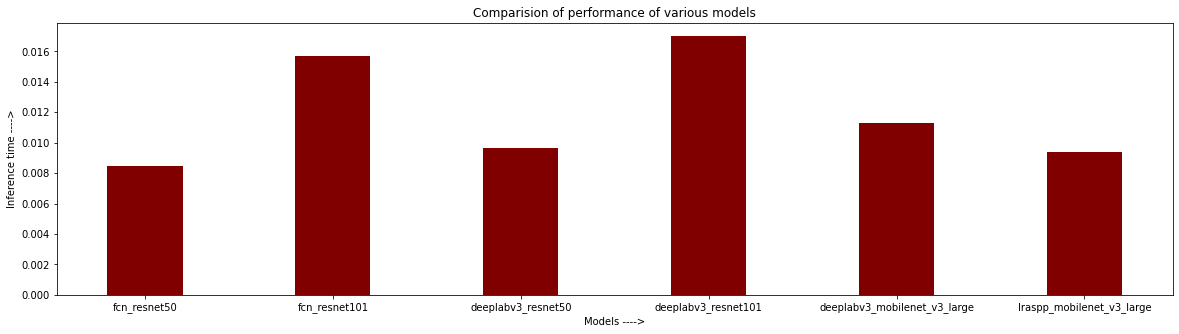

In [83]:
# Plotting Bar chart for Inference Times
 
Models = ['fcn_resnet50',
          'fcn_resnet101',
          'deeplabv3_resnet50',
          'deeplabv3_resnet101',
          'deeplabv3_mobilenet_v3_large',
          'lraspp_mobilenet_v3_large']

inference_time = [fcn_resnet50_infer_time_avg_gpu,
                  fcn_resnet101_infer_time_avg_gpu,
                  deeplabv3_resnet50_infer_time_avg_gpu,
                  deeplabv3_resnet101_infer_time_avg_gpu,
                  deeplabv3_mobilenet_v3_large_infer_time_avg_gpu,
                  lraspp_mobilenet_v3_large_infer_time_avg_gpu]

fig = plt.figure(figsize = (20, 5))

# creating the bar plot
plt.bar(Models, inference_time, color ='maroon',width = 0.4)

plt.xlabel("Models ---->")
plt.ylabel("Inference time ---->")
plt.title("Comparision of performance of various models")
plt.show()